In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [7]:
rcParams["figure.figsize"] = 10,10
df = pd.read_csv("monthly_milk_production.csv", index_col='Date',parse_dates=True)
df.index.freq='MS'

In [8]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

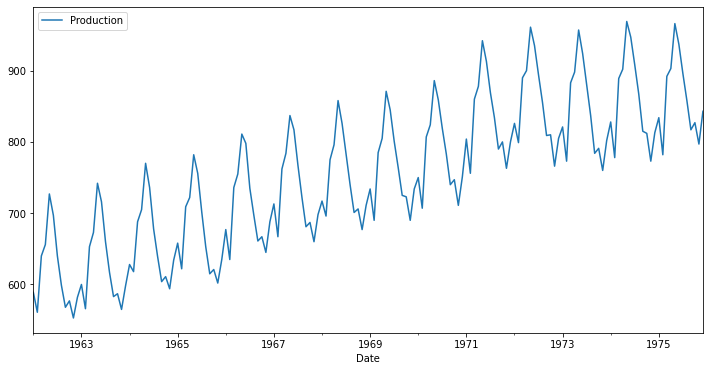

In [9]:
df.plot(figsize=(12,6))

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

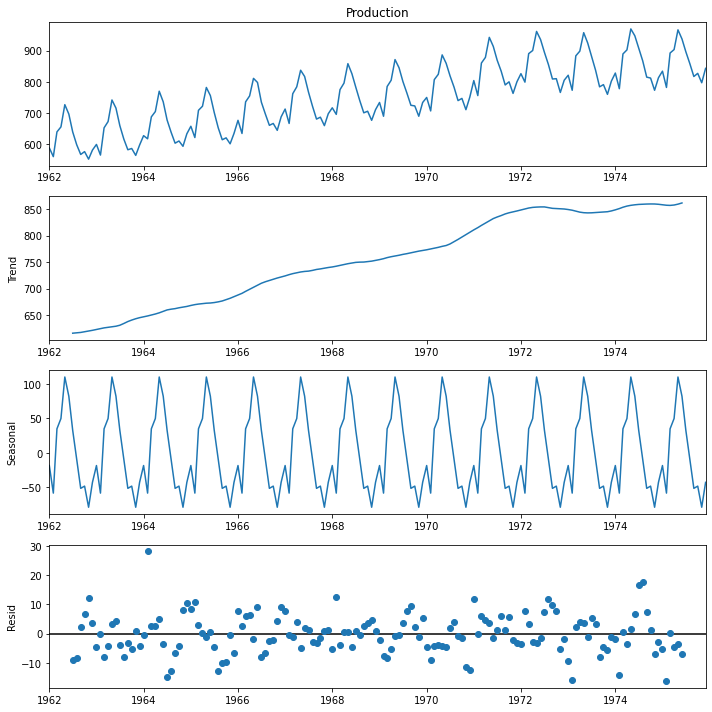

In [11]:
results = seasonal_decompose(df['Production'])
results.plot();

In [12]:
len(df)

168

In [13]:
train = df.iloc[:156]
test = df.iloc[156:]

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [15]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
scaled_test

array([[0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385],
       [0.58653846],
       [0.69711538]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
X,y = generator[2]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.20913462 0.24759615 0.41826923]
Predict this y: 
 [[0.34615385]]


In [20]:
X.shape

(1, 3, 1)

In [21]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 18ms/step - loss: 0.0395
Epoch 2/50
144/144 [==============================] - 2s 13ms/step - loss: 0.0191
Epoch 3/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0143
Epoch 4/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0153
Epoch 5/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0092
Epoch 6/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0078
Epoch 7/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0056
Epoch 8/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0049
Epoch 9/50
144/144 [==============================] - 2s 13ms/step - loss: 0.0052
Epoch 10/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0051
Epoch 11/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0043
Epoch 12/50
144/144 [==============================] - 2s 13ms/step - loss: 0.0044
Epoch 13/50
1

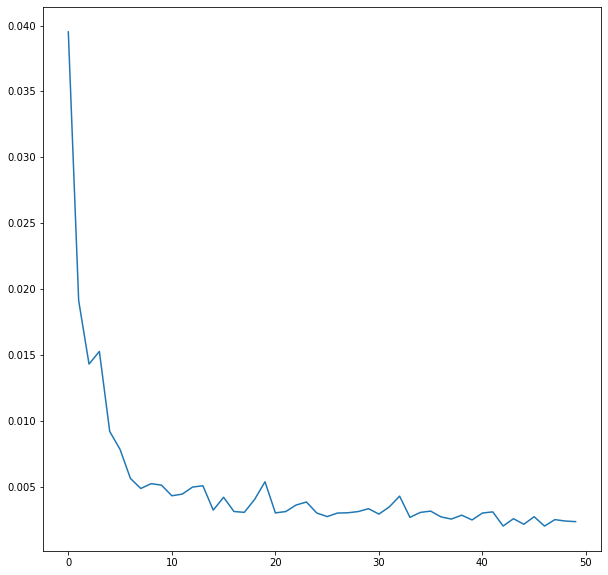

In [26]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [20]:
last_train_batch = scaled_train[-12:]

In [21]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

NameError: name 'n_input' is not defined

In [22]:
model.predict(last_train_batch)

NameError: name 'model' is not defined

In [30]:
scaled_test[0]

array([0.67548077])

In [19]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

NameError: name 'n_input' is not defined

In [32]:
test_predictions

[array([0.59067726], dtype=float32),
 array([0.55255425], dtype=float32),
 array([0.71839935], dtype=float32),
 array([0.7884129], dtype=float32),
 array([0.9026563], dtype=float32),
 array([0.8821822], dtype=float32),
 array([0.81173956], dtype=float32),
 array([0.71705246], dtype=float32),
 array([0.6133986], dtype=float32),
 array([0.5764496], dtype=float32),
 array([0.52191746], dtype=float32),
 array([0.55617726], dtype=float32)]

In [33]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [18]:
true_predictions = scaler.inverse_transform(test_predictions)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [36]:
test['Predictions'] = true_predictions

C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


ERROR! Session/line number was not unique in database. History logging moved to new session 185


<AxesSubplot:xlabel='Date'>

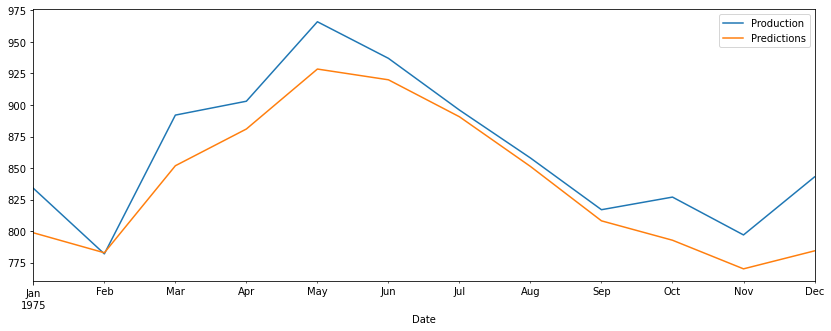

In [37]:
test.plot(figsize=(14,5))

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

29.60561254945198
